In [1]:
#|default_exp app_v1

## Reimplementing DiffEdit

In this notebook we're going to reimplement the semantic image editing process illustrated in the [DiffEdit](https://arxiv.org/abs/2210.11427) paper. In the paper, the authors proposed using text input to create a mask of the queried object, and essentially using an img2img type of processing, such that changes could be made to the object without making changes to the context of the image. 

## Example

<center><img alt="DiffEdit Workflow" width="1000" src="imgs/diffusion_method2.jpg" /></center>

### Imports

In [2]:
#| export
from base64 import b64encode

import os
import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login
from fastai.vision.all import *

from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer


import tsensor
from lolviz import *


import logging

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
logging.disable(logging.WARNING)
torch.manual_seed(1);

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

## Load Autoencoder, VAE, ClipTokenizer, Clip Text Encoder, and Scheduler

In [4]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(torch_device).half()
text_encoder = text_encoder.to(torch_device).half()
unet = unet.to(torch_device).half();

## Define Functions for Imamge -> Latent and Latent -> Image Conversion

In [5]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch, size (1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device).half()*2.0-1.0)
    return 0.18215 * latent.latent_dist.sample()

In [6]:
def latent_to_pil(latents):
    # batch of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [7]:
def get_text_embedding(prompt):
    max_length = tokenizer.model_max_length
    tokens = tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(tokens.input_ids.to(torch_device))[0]
    return text_embeddings

### Import Image

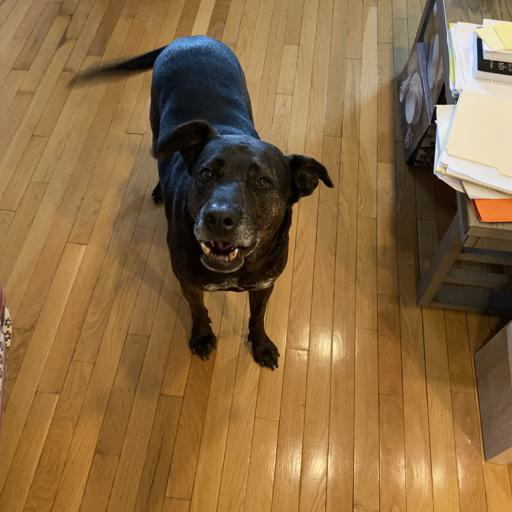

In [8]:
#| export
im = Image.open('imgs/IMG_4104_512.jpg')
im

## Set Up Pipeline to Return Latents

Create initial prompt and unconditioned prompt

In [9]:
prompt = ["a wolf staring at the viewer, by Howard Arkley"]
uncond_prompt = ""

Convert the prompt to a text embedding

In [10]:
text_embeds = get_text_embedding(prompt)
uncond_text_embeds = get_text_embedding(uncond_prompt)

In [11]:
# Concatonate the unconditioned text and prompt embeddings
comb_embeds = torch.cat([uncond_text_embeds, text_embeds])

Define the number of steps in the scheduler

In [12]:
scheduler.set_timesteps(50)

Convert the Image to Latent

In [13]:
im_latents = pil_to_latent(im)

Find the inital time step based on the strength of the gaussian noise, in the case of the DiffEdit paper, they found 0.5 to be a good working percentage

The original model was trained on 1000 steps, we're going to use considerably fewer than that, so we need to find what timestep our noise level is at in the original training schedule 

In [42]:
strength = 0.5
num_inference_steps = 50
init_timestep = int(strength * num_inference_steps)

In [43]:
init_timestep

25

In [48]:
timesteps

tensor([489.31], device='cuda:0', dtype=torch.float64)

In the schedule, get the index of the timestep that corresponds to `init_timestep` defined above

In [44]:
timesteps = scheduler.timesteps[-init_timestep]
timesteps

tensor(489.31, dtype=torch.float64)

create a tensor of the timesteps and send to cuda

In [45]:
timesteps = torch.tensor([timesteps], device=torch_device)
timesteps

tensor([489.31], device='cuda:0', dtype=torch.float64)

In [46]:
timesteps

tensor([489.31], device='cuda:0', dtype=torch.float64)

create the `initial noise` from the initial latents, make sure to match the `dtype` of the initial latents

In [17]:
init_noise = torch.randn(im_latents.shape, dtype=im_latents.dtype, device=torch_device)

In [18]:
im_noise = latent_to_pil(init_noise)

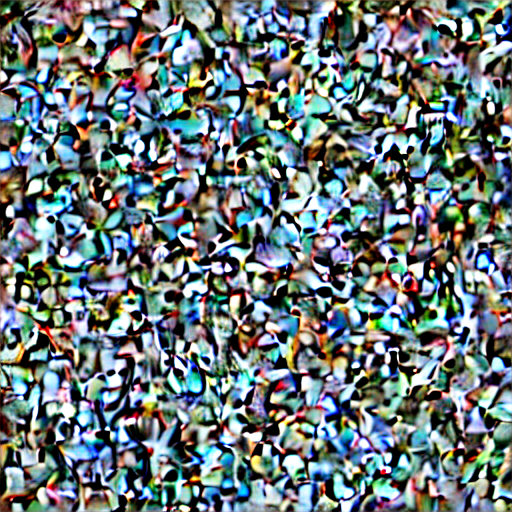

In [19]:
im_noise[0]

create the `latents` by using the `scheduler` to `add_noise`, passing the inital latents, noise, and timestep for the noise

In [20]:
im_latents, init_noise, timesteps

(tensor([[[[ 0.39,  0.83,  0.60,  ..., -0.67,  0.68, -0.11],
           [ 0.68,  0.21,  0.45,  ..., -0.43,  0.70,  0.87],
           [ 0.55,  0.90,  0.89,  ...,  2.29,  1.78,  1.38],
           ...,
           [ 0.74,  0.58,  0.54,  ...,  1.58,  1.17,  1.01],
           [ 0.75,  0.37,  0.84,  ...,  0.92,  1.33,  1.35],
           [ 0.23,  0.65,  0.75,  ...,  1.15,  1.38,  1.26]],
 
          [[-0.17,  0.22,  0.08,  ...,  0.21, -0.80,  0.22],
           [ 0.67, -0.47,  1.05,  ...,  0.39,  0.43, -0.58],
           [ 0.06,  0.41,  0.21,  ..., -0.21, -0.76,  0.15],
           ...,
           [-0.59,  0.45,  0.67,  ...,  0.16,  0.33,  0.33],
           [ 0.17, -0.34,  0.89,  ...,  0.64,  1.13,  0.40],
           [-0.52,  0.35,  0.45,  ...,  0.88,  0.35,  0.91]],
 
          [[-0.95,  0.56, -0.44,  ..., -0.23,  0.28, -0.72],
           [-0.27, -0.34, -0.38,  ...,  0.69,  0.98,  1.01],
           [ 0.32, -0.62,  0.31,  ..., -0.16,  0.01,  0.51],
           ...,
           [-0.76,  0.18,  0.26

tensor(489.31, dtype=torch.float64)

In [40]:
timesteps[0]

tensor(489.25, device='cuda:0', dtype=torch.float16)

In [47]:
latents = scheduler.add_noise(im_latents, init_noise, timesteps)

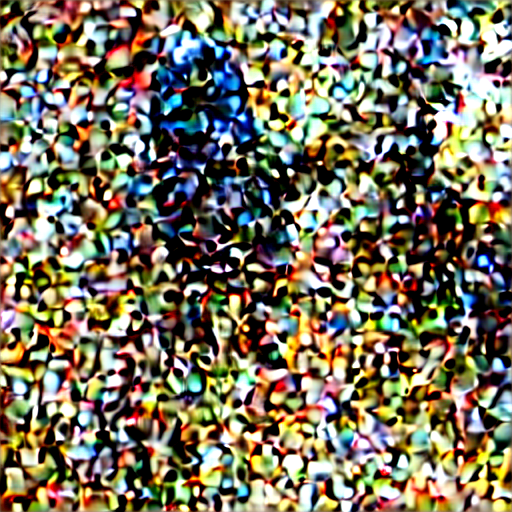

In [49]:
latent_to_pil(latents)[0]

compute the timestep to start the diffusion loop
    - create a `start` of the max 

In [25]:
import nbdev
nbdev.export.nb_export('diffedit.ipynb', 'app_v1')
print("export successful")

export successful
